In [96]:
from datetime import datetime
from alpha_realtime_stock import AlphaRealtimeStock
import time
import timeit
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout   ## importing layers of Neural network
from keras.callbacks import ModelCheckpoint     ## imporing modelcheck pointer
from keras.losses import MSE                  ## importing error function
from keras.optimizers import Adam              ## importing optimizer
from keras.activations import relu


def get_crumbs():
    """
    get crumb  from yahoo finance
    returns crumb
    """
    url = 'https://finance.yahoo.com/quote'
    header = {'Connection': 'keep-alive',
              'Expires': '-1',
              'Upgrade-Insecure-Requests': '1',
              'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) \
               AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'
              }

    website = requests.get(url, headers=header)
    soup = BeautifulSoup(website.text, 'lxml')
    crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))
    return crumb[0]

crumb = get_crumbs()
ticker_list = ['TSLA']
stock_collection = {}
for ticker in ticker_list:
    stock = AlphaRealtimeStock(ticker, crumb)
    stock_collection[ticker] = stock
# while True:
#     print(datetime.now().strftime("%H:%M:%S"))
    for ticker in ticker_list:
        stock = stock_collection[ticker]
        stock.fetch_webdata()
#         df = stock.get_Stoch_RSI_Indicator()
#         print(df.tail())
#     end = timeit.default_timer()
#     time.sleep(5)

In [97]:
data_tsla = stock.fetch_webdata()

In [98]:
data_tsla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Datetime  3431 non-null   datetime64[ns]
 1   Open      3428 non-null   float64       
 2   High      3428 non-null   float64       
 3   Low       3428 non-null   float64       
 4   Close     3428 non-null   float64       
 5   Volume    3428 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 161.0 KB


In [99]:
data_tsla = data_tsla.dropna()

In [100]:
data_tsla.head()

,Datetime,Open,High,Low,Close,Volume
0,2020-09-08 02:15:00,391.00,392.00,385.55,385.84,0.0
1,2020-09-08 02:16:00,386.96,393.79,386.96,393.21,0.0
2,2020-09-08 02:17:00,394.97,395.00,391.00,391.78,0.0
3,2020-09-08 02:18:00,391.00,391.02,388.61,391.00,0.0
4,2020-09-08 02:19:00,390.49,390.54,388.10,388.10,0.0


In [101]:
data_tsla.tail()

,Datetime,Open,High,Low,Close,Volume
3425,2020-09-11 13:53:00,371.412415,371.989990,371.179993,371.869995,120250.0
3426,2020-09-11 13:54:00,371.739990,372.350006,371.579987,371.950012,165598.0
3427,2020-09-11 13:55:00,372.079987,372.209991,371.630005,372.140015,144148.0
3428,2020-09-11 13:56:00,372.160004,373.000000,371.970001,372.880005,190794.0
3430,2020-09-11 13:57:40,372.519989,372.519989,372.519989,372.519989,0.0


In [102]:
tsla_data.shape

(3379, 6)

In [86]:
### We will focus on the open price

In [113]:
df = data_tsla['Close'].values
print("Total No. of days of TSLA's Stocks :",df.shape[0])

Total No. of days of TSLA's Stocks : 3428


In [114]:
df

array([385.84      , 393.21      , 391.78      , ..., 372.14001465,
       372.88000488, 372.51998901])

In [115]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print('Training stock :',dataset_train.shape[0],'days')
print('Test stock :',dataset_test.shape[0],'days')

Training stock : 2742 days
Test stock : 736 days


In [116]:
dataset_test

array([378.        , 377.6       , 376.9       , 376.25      ,
       376.        , 375.        , 375.88      , 376.48      ,
       376.44      , 377.        , 376.25      , 376.17      ,
       375.8       , 375.95      , 376.3       , 376.5       ,
       376.5       , 376.5       , 375.77      , 375.        ,
       374.5       , 375.24      , 375.49      , 374.5       ,
       374.25      , 374.25      , 375.6       , 375.46      ,
       375.4       , 376.        , 375.8       , 375.31      ,
       375.4       , 374.7       , 375.        , 375.1       ,
       375.37      , 375.7       , 376.35      , 376.        ,
       375.5       , 375.12      , 375.6       , 375.21      ,
       375.5       , 375.42      , 376.02      , 376.8       ,
       376.4       , 376.77      , 377.        , 376.35      ,
       376.5       , 377.        , 377.69      , 377.        ,
       376.6       , 375.5       , 375.45      , 375.35      ,
       376.        , 376.9       , 376.13      , 376.64

In [109]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train.reshape(-1, 1))
dataset_test = scaler.transform(dataset_test.reshape(-1, 1))


In [110]:
def create_dataset(df,n):
    '''
    Function to prepare data for the LSTM
    
    '''
    
    x = []
    y = []
  
    for i in range(n, df.shape[0]):
        x.append(df[i-n:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [111]:
x_train, y_train = create_dataset(dataset_train,50)
x_test, y_test = create_dataset(dataset_test,50)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print('Training data shape',x_train.shape)
print('Test data shape',x_test.shape)

Training data shape (2692, 50, 1)
Test data shape (686, 50, 1)


In [117]:
x_test

array([[[0.77077312],
        [0.76631778],
        [0.75852094],
        ...,
        [0.75740711],
        [0.75295177],
        [0.75707296]],

       [[0.76631778],
        [0.75852094],
        [0.75128102],
        ...,
        [0.75295177],
        [0.75707296],
        [0.75963478]],

       [[0.75852094],
        [0.75128102],
        [0.74849644],
        ...,
        [0.75707296],
        [0.75963478],
        [0.75239486]],

       ...,

       [[0.66339936],
        [0.67431505],
        [0.66540452],
        ...,
        [0.69837391],
        [0.70249504],
        [0.7033863 ]],

       [[0.67431505],
        [0.66540452],
        [0.66796612],
        ...,
        [0.70249504],
        [0.7033863 ],
        [0.70550261]],

       [[0.66540452],
        [0.66796612],
        [0.64713748],
        ...,
        [0.7033863 ],
        [0.70550261],
        [0.71374487]]])

In [120]:
model = Sequential()

model.add(LSTM(units=96, 
               return_sequences=True,
               input_shape=(x_train.shape[1], 1)))

model.add(Dropout(0.2))

model.add(LSTM(units=96, 
               return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units=96, 
               return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units=96))

model.add(Dropout(0.2))

model.add(Dense(units=1))

In [121]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 96)               

In [122]:
model.compile(loss=MSE, optimizer=Adam())


In [123]:
checkpointer = ModelCheckpoint(filepath='tesla.stock_prediction.hdf5',save_best_only=True,verbose=1)

callbacks = [checkpointer]

In [124]:
history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,callbacks=[checkpointer],validation_split=0.05)


Epoch 1/70
80/80 [==============================] - ETA: 0s - loss: 0.0169
Epoch 00001: val_loss improved from inf to 0.00039, saving model to tesla.stock_prediction.hdf5
80/80 [==============================] - 6s 80ms/step - loss: 0.0169 - val_loss: 3.8720e-04
Epoch 2/70
80/80 [==============================] - ETA: 0s - loss: 0.0042
Epoch 00002: val_loss did not improve from 0.00039
80/80 [==============================] - 5s 66ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 3/70
80/80 [==============================] - ETA: 0s - loss: 0.0037
Epoch 00003: val_loss did not improve from 0.00039
80/80 [==============================] - 5s 68ms/step - loss: 0.0037 - val_loss: 7.6841e-04
Epoch 4/70
80/80 [==============================] - ETA: 0s - loss: 0.0033
Epoch 00004: val_loss improved from 0.00039 to 0.00026, saving model to tesla.stock_prediction.hdf5
80/80 [==============================] - 6s 70ms/step - loss: 0.0033 - val_loss: 2.6438e-04
Epoch 5/70
80/80 [====================

In [125]:
model = load_model('tesla.stock_prediction.hdf5')


In [126]:
import matplotlib.pyplot as plt

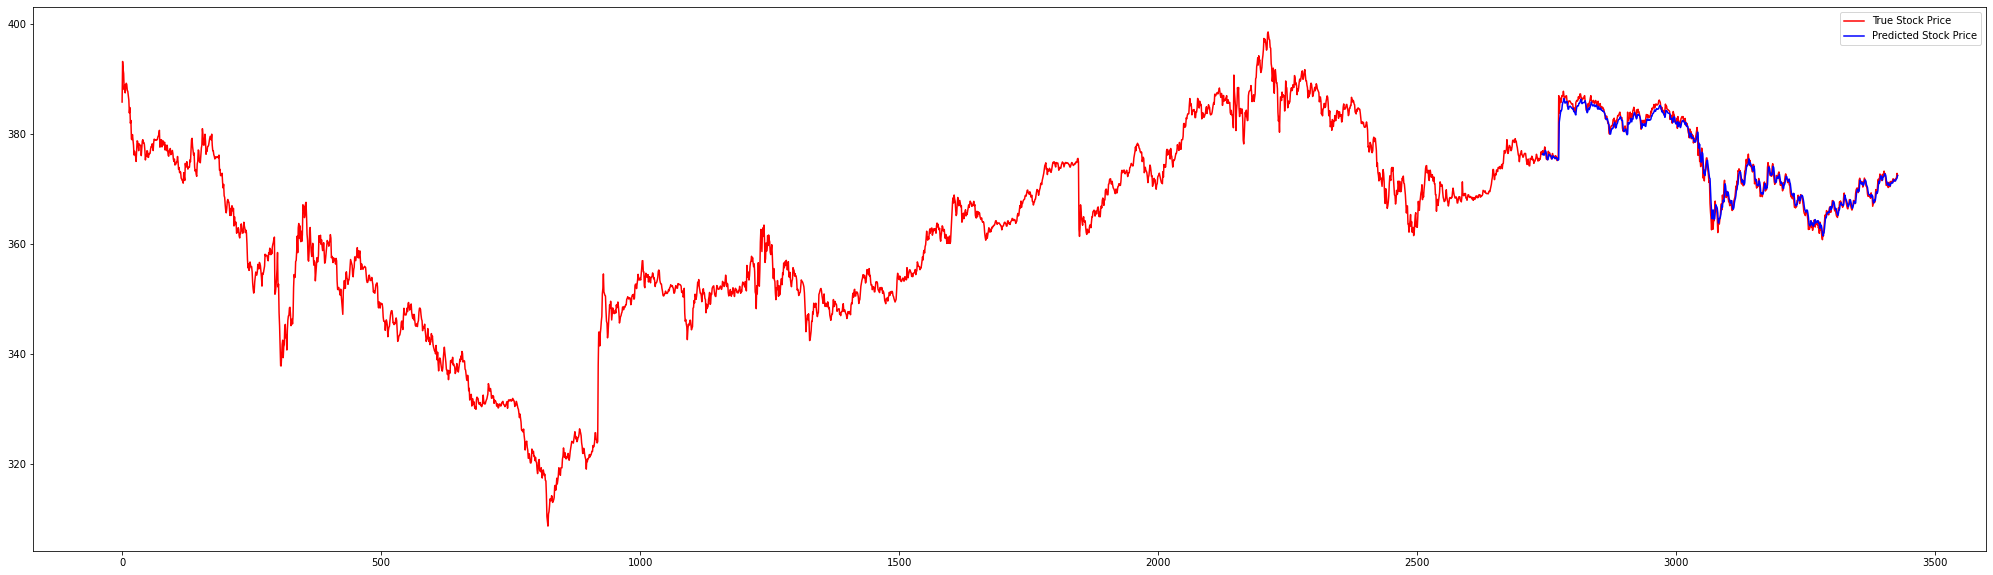

In [127]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(35,10))
plt.plot(df, color='red',  label="True Stock Price",)
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Stock Price')
plt.legend()

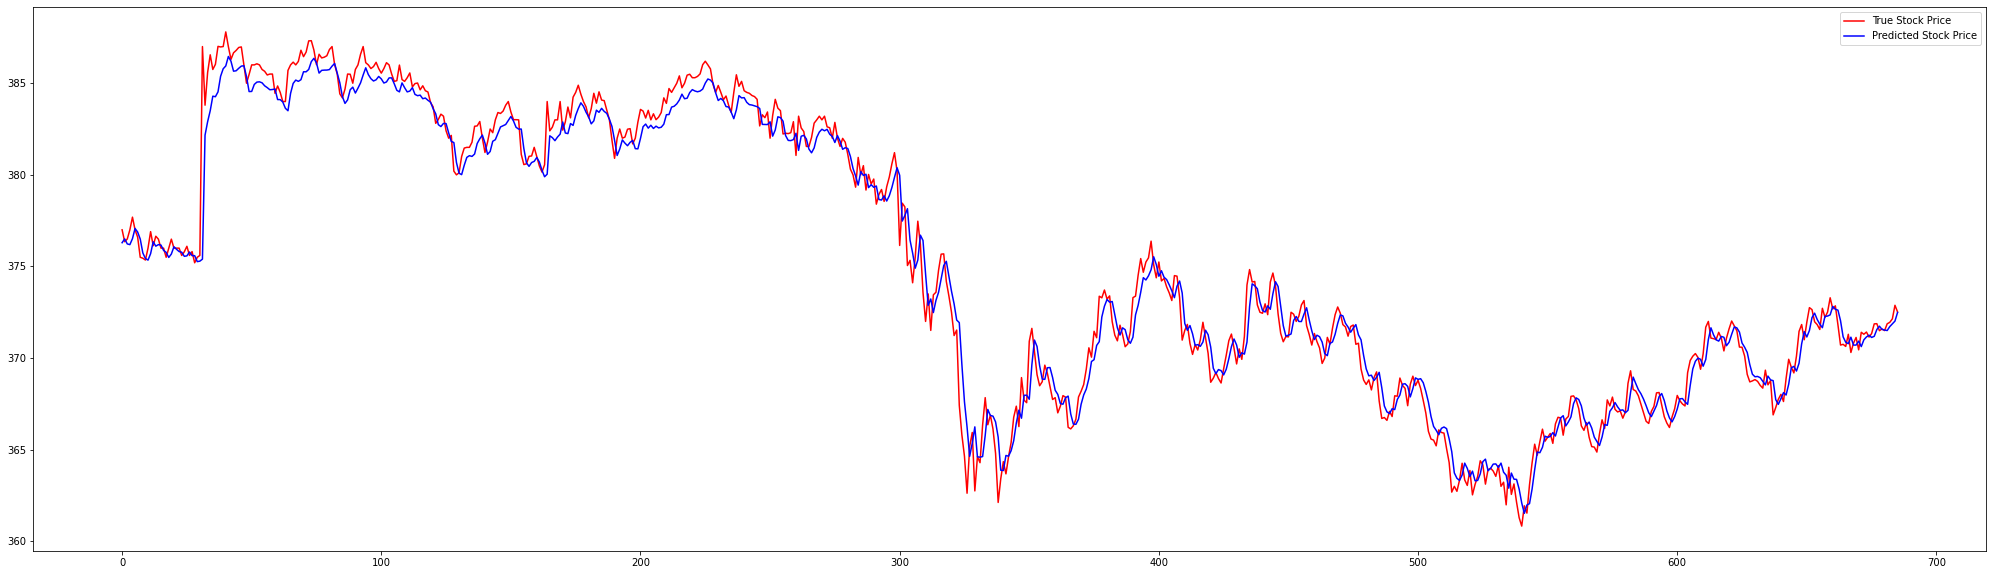

In [128]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


fig, ax = plt.subplots(figsize=(35,10))
ax.plot(y_test_scaled, color='red', label='True Stock Price')
plt.plot(predictions, color='blue', label='Predicted Stock Price')
plt.legend()